In [1]:
# 01_data_cleaning.ipynb

import pandas as pd
import numpy as np
from pathlib import Path

# ---- Paths ----
PROJECT_ROOT = Path("/home/python/Downloads/Claim_severity_project")
DATA_DIR = PROJECT_ROOT / "data"

# ---- Load raw data ----
sev_df = pd.read_csv(DATA_DIR / "freMTPL2sev.csv")
freq_df = pd.read_csv(DATA_DIR / "freMTPL2freq.csv")

print("sev_df shape:", sev_df.shape)
print("freq_df shape:", freq_df.shape)

# ---- Merge (inner: only policies with claims) ----
df = pd.merge(freq_df, sev_df, on="IDpol", how="inner")
print("Merged shape:", df.shape)

# ---- Handle missing values ----
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Fill numeric with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Cast categoricals
df[cat_cols] = df[cat_cols].astype("category")

# ---- Feature engineering ----

# Interaction: power × driver age
if "VehPower" in df.columns and "DrivAge" in df.columns:
    df["Power_x_DrivAge"] = df["VehPower"] * df["DrivAge"]

# Age buckets
if "DrivAge" in df.columns:
    df["DrivAge_bucket"] = pd.cut(
        df["DrivAge"],
        bins=[18, 25, 35, 50, 70],
        labels=["18-25", "26-35", "36-50", "51-70"],
        include_lowest=True
    ).astype("category")


print("\nColumns after feature engineering:")
print(df.dtypes)

# ---- Save cleaned data ----
OUTPUT_PATH = DATA_DIR / "processed_severity.csv"
df.to_csv(OUTPUT_PATH, index=False)
print("\nSaved cleaned dataset to:", OUTPUT_PATH)


sev_df shape: (26639, 2)
freq_df shape: (678013, 12)
Merged shape: (26444, 13)

Columns after feature engineering:
IDpol               float64
ClaimNb               int64
Exposure            float64
VehPower              int64
VehAge                int64
DrivAge               int64
BonusMalus            int64
VehBrand           category
VehGas             category
Area               category
Density               int64
Region             category
ClaimAmount         float64
Power_x_DrivAge       int64
DrivAge_bucket     category
dtype: object

Saved cleaned dataset to: /home/python/Downloads/Claim_severity_project/data/processed_severity.csv


In [1]:
# 03_modeling_lightgbm.ipynb

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import lightgbm as lgb
import joblib

# ---- Paths ----
PROJECT_ROOT = Path("/home/python/Downloads/Claim_severity_project")
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
DASHBOARD_DIR = PROJECT_ROOT / "dashboard"

MODELS_DIR.mkdir(exist_ok=True)
DASHBOARD_DIR.mkdir(exist_ok=True)

# ---- Load processed data ----
df = pd.read_csv(DATA_DIR / "processed_severity.csv")
print("Data shape:", df.shape)

# ---- Target & features ----

TARGET_COL = "ClaimAmount"

# Keep IDpol aside (for dashboard later)
id_col = df["IDpol"]

X = df.drop(columns=[TARGET_COL, "IDpol"])
y = df[TARGET_COL]

print("Initial X shape (before dummies):", X.shape)

# ---- One-hot encode categoricals ----
X = pd.get_dummies(X, drop_first=True)
print("X shape (after dummies):", X.shape)


X_all = X.copy()

# ---- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# ---- Evaluation helper ----
def evaluate(model, name):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name:20s} → MAE: {mae:,.2f}, RMSE: {rmse:,.2f}")
    return mae, rmse

# ---- Baseline models ----
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(lr, "Linear Regression")

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
evaluate(rf, "Random Forest")

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
evaluate(gb, "Gradient Boosting")

# ---- LightGBM model (main) ----
lgbm = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1  
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse"
)

evaluate(lgbm, "LightGBM")

print("Has booster_? ", hasattr(lgbm, "booster_"))  # should be True

# ---- Save fitted model ----
model_path = MODELS_DIR / "lgbm_severity.pkl"
joblib.dump(lgbm, model_path)
print("Saved trained LightGBM model to:", model_path)

# ---- Create data for Tableau dashboard ----

preds_all = lgbm.predict(X_all)

dashboard_df = pd.DataFrame({
    "IDpol": id_col,
    "Actual": y,
    "Pred_LGBM": preds_all
})

dashboard_path = DASHBOARD_DIR / "severity_dashboard_data.csv"
dashboard_df.to_csv(dashboard_path, index=False)
print("Saved dashboard data to:", dashboard_path)


Data shape: (26444, 15)
Initial X shape (before dummies): (26444, 13)
X shape (after dummies): (26444, 47)
X_train: (21155, 47)
X_test: (5289, 47)
Linear Regression    → MAE: 2,356.95, RMSE: 9,551.99
Random Forest        → MAE: 2,494.96, RMSE: 14,490.12
Gradient Boosting    → MAE: 2,364.74, RMSE: 14,546.45
LightGBM             → MAE: 3,601.53, RMSE: 14,651.16
Has booster_?  True
Saved trained LightGBM model to: /home/python/Downloads/Claim_severity_project/models/lgbm_severity.pkl
Saved dashboard data to: /home/python/Downloads/Claim_severity_project/dashboard/severity_dashboard_data.csv


X shape for SHAP: (26444, 47)
Has booster_?  True


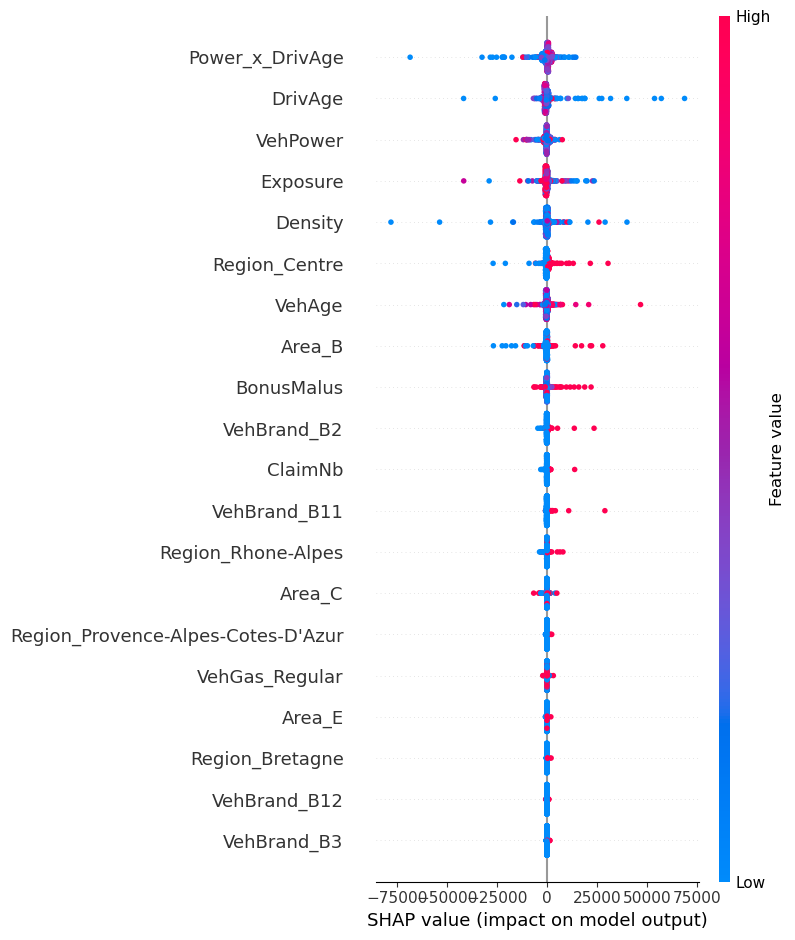

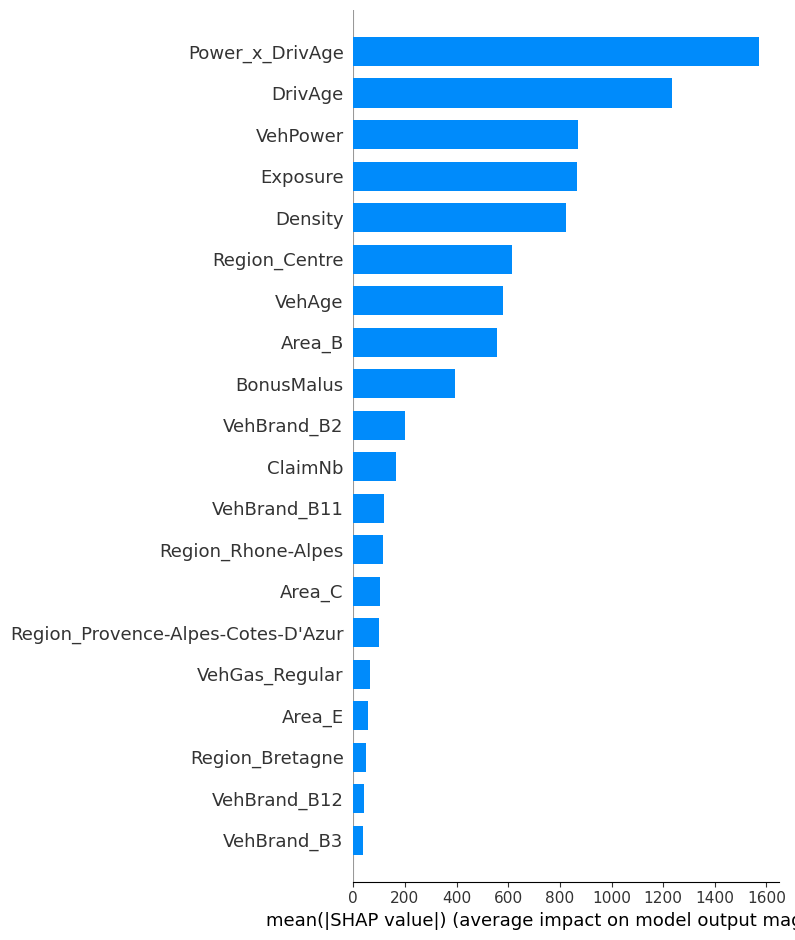

In [2]:
# 04_shap_explainability.ipynb

import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import shap

# ---- Paths ----
PROJECT_ROOT = Path("/home/python/Downloads/Claim_severity_project")
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"

# ---- Load data ----
df = pd.read_csv(DATA_DIR / "processed_severity.csv")

TARGET_COL = "ClaimAmount"  
X = df.drop(columns=[TARGET_COL, "IDpol"])  

# Same encoding as in modeling notebook
X = pd.get_dummies(X, drop_first=True)
print("X shape for SHAP:", X.shape)

# ---- Load fitted model ----
lgbm = joblib.load(MODELS_DIR / "lgbm_severity.pkl")
print("Has booster_? ", hasattr(lgbm, "booster_"))  

# ---- SHAP explainer ----
shap.initjs()

explainer = shap.TreeExplainer(lgbm)

# Use a sample of rows so it's faster (max 1000)
n_sample = min(1000, len(X))
X_sample = X.sample(n_sample, random_state=42)

shap_values = explainer.shap_values(X_sample)

# ---- Global feature importance: summary plot ----
shap.summary_plot(shap_values, X_sample)

# ---- Bar plot version ----
shap.summary_plot(shap_values, X_sample, plot_type="bar")
